In [1]:
import simpy
import networkx as nx
import datetime

import itertools
import requests
import pickle
import io

import pandas as pd
import geopandas as gpd

import simpy

import itertools

import matplotlib.pyplot as plt

import pint
ureg = pint.UnitRegistry()

In [2]:
url = 'https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1'
resp = requests.get(url)

In [3]:
graph = pickle.load(io.BytesIO(resp.content))
trips_gdf = gpd.read_parquet('week_38_routes.parquet')

In [4]:
nodes = {
    "Nijmegen": "22638188",
    "Duisburg": "FN96",
    "Rotterdam": "18008346",
}

145699.13091711738

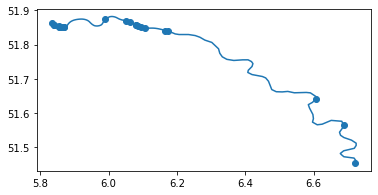

In [5]:
def get_route_gdfs(a, b):
    route = nx.shortest_path(graph, source=a, target=b, weight="length_m")


    nodes = []
    for n in route:
        node = graph.nodes[n]
        nodes.append(node)
    
    node_df = pd.DataFrame(nodes)
    geometry = gpd.GeoSeries.from_wkt(node_df['Wkt'])
    node_gdf = gpd.GeoDataFrame(node_df, geometry=geometry)

    edges = []
    for a, b in zip(route[:-1], route[1:]):
        edge = graph.edges[(a, b)]
        edges.append(edge)

    edge_df = pd.DataFrame(edges)
    geometry = gpd.GeoSeries.from_wkt(edge_df['Wkt'])
    edge_gdf = gpd.GeoDataFrame(edge_df, geometry=geometry)
    
    
    result = {"edge": edge_gdf, "node": node_gdf}
    return result


route_gdfs = get_route_gdfs(nodes['Nijmegen'], nodes['Duisburg'])
edge_gdf = route_gdfs["edge"]
node_gdf = route_gdfs["node"]

fig, ax = plt.subplots()

edge_gdf.plot(ax=ax)
node_gdf.plot(ax=ax)
    
edge_gdf["length_m"].sum()

In [6]:
source_gdf = trips_gdf.groupby(["source"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
target_gdf = trips_gdf.groupby(["target"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg = trips_gdf.groupby(["route"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg

,sum,count
route,,
Duisburg-Nijmegen,537.0,8
Duisburg-Rotterdam,18583.0,794
Nijmegen-Duisburg,473.0,7
Nijmegen-Rotterdam,5274.0,59
Rotterdam-Duisburg,23334.0,810
Rotterdam-Nijmegen,6413.0,67


In [7]:
max_capacity = trips_gdf['v30_4_Containers_TEU_S'].sum()

In [8]:
env = simpy.Environment()

In [9]:
def create_container(row, env, fill):
    if fill:
        init = row['sum']
    else:
        init = 0
    
    container = simpy.Container(env=env, capacity=max_capacity, init=init)
    return container
    
source_gdf["container"] = source_gdf.apply(create_container, env=env, fill=True, axis=1)
target_gdf["container"] = target_gdf.apply(create_container, env=env, fill=False, axis=1)
trips_gdf_agg["container"] = trips_gdf_agg.apply(create_container, env=env, fill=True, axis=1)
trips_gdf_agg

,sum,count,container
route,,,
Duisburg-Nijmegen,537.0,8,<simpy.resources.container.Container object at...
Duisburg-Rotterdam,18583.0,794,<simpy.resources.container.Container object at...
Nijmegen-Duisburg,473.0,7,<simpy.resources.container.Container object at...
Nijmegen-Rotterdam,5274.0,59,<simpy.resources.container.Container object at...
Rotterdam-Duisburg,23334.0,810,<simpy.resources.container.Container object at...
Rotterdam-Nijmegen,6413.0,67,<simpy.resources.container.Container object at...


In [10]:
trips_gdf_rotterdam_source = trips_gdf[trips_gdf['source'] == 'Rotterdam']
trip = trips_gdf_rotterdam_source.iloc[0]

In [11]:
trip = {
    "source": "Rotterdam",
    "target": "Duisburg",
    "target_hub": "Nijmegen",
    "ship_cargo": simpy.Container(env, capacity=200, init=0)
}

In [12]:
import contextlib
COUNT = itertools.count()

class LogDecorator(contextlib.ContextDecorator):
    logbook = []
    def __init__(self, env, message='', **kwargs):
        """initialize the logbook"""
        super().__init__()
        self.env = env

        
        self.message = message
        self.kwargs = kwargs

        self.activity_id = next(COUNT)

    def log_entry(
        self,
        message=None,
        timestamp=None,
        value=None,
        geometry=None,
        activity_id=None,
        activity_state=None,
        **kwargs
    ):
        timestamp = env.now
        entry = {
            "Message": message,
            "Timestamp": datetime.datetime.utcfromtimestamp(timestamp),
            "Value": value,
            "geometry": geometry,
            "ActivityID": activity_id or next(COUNT),
            "ActivityState": activity_state,
            "Meta": kwargs,
        }
        self.logbook.append(entry)

    def __enter__(self):
        """log a start message on entrance"""
        kwargs = {}
        kwargs.update(self.kwargs)
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            state="START"
        )
        return self

    def __exit__(self, *exc):
        """log a stop message on exit"""
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            state="STOP"
        )
        return False



In [13]:
def load(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        source_container.get(ship_container.capacity) as get_req, 
        ship_container.put(ship_container.capacity) as put_req,
    ):
        with LogDecorator(env, message="get container"):
            yield get_req
        yield put_req
        yield env.timeout(ship_container.capacity * loading_rate)
        print("Cargo loaded in ship", env.now)


def unload(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        ship_container.get(ship_container.capacity) as get_req,
        target_container.put(ship_container.capacity) as put_req, 
    ):
        print("Loading cargo from ship", env.now)
        yield get_req
        print("Ship cargo available")
        yield put_req
        print("Target cargo available")
        yield env.timeout(ship_container.capacity * loading_rate)
        print("Cargo loaded in target", env.now)


def move(trip):
    a = nodes[trip["source"]]
    b = nodes[trip["target_hub"]]
    route_gdfs = get_route_gdfs(a, b)
    edge_gdf = route_gdfs["edge"]
    node_gdf = route_gdfs["node"]

    route_length_m = edge_gdf["length_m"].sum()
    velocity = 4
    duration = route_length_m / velocity # m / m/s = m * s / m = s
    print("Moving from", a, env.now)
    yield env.timeout(duration)
    print("Arrived at", b, env.now)


def cycle(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    while source_container.level:
        yield from load(trip)
        yield from move(trip)
        yield from unload(trip)

env.process(cycle(trip))

env.run()

Cargo loaded in ship 4000
Moving from 18008346 4000
Arrived at 22638188 59929.68754816057
Loading cargo from ship 59929.68754816057
Ship cargo available
Target cargo available
Cargo loaded in target 63929.68754816057
Cargo loaded in ship 67929.68754816057
Moving from 18008346 67929.68754816057
Arrived at 22638188 123859.37509632114
Loading cargo from ship 123859.37509632114
Ship cargo available
Target cargo available
Cargo loaded in target 127859.37509632114
Cargo loaded in ship 131859.37509632114
Moving from 18008346 131859.37509632114
Arrived at 22638188 187789.06264448172
Loading cargo from ship 187789.06264448172
Ship cargo available
Target cargo available
Cargo loaded in target 191789.06264448172
Cargo loaded in ship 195789.06264448172
Moving from 18008346 195789.06264448172
Arrived at 22638188 251718.75019264227
Loading cargo from ship 251718.75019264227
Ship cargo available
Target cargo available
Cargo loaded in target 255718.75019264227
Cargo loaded in ship 259718.75019264227
M

In [15]:
pd.DataFrame(LogDecorator.logbook)

,Message,Timestamp,Value,geometry,ActivityID,ActivityState,Meta
0,get container,1970-01-01 00:00:00.000000,None,None,1,None,{'state': 'START'}
1,get container,1970-01-01 00:00:00.000000,None,None,2,None,{'state': 'STOP'}
2,get container,1970-01-01 17:45:29.687548,None,None,3,None,{'state': 'START'}
3,get container,1970-01-01 17:45:29.687548,None,None,3,None,{'state': 'STOP'}
4,get container,1970-01-02 11:30:59.375096,None,None,4,None,{'state': 'START'}
...,...,...,...,...,...,...,...
228,get container,1970-03-26 08:26:24.380490,None,None,116,None,{'state': 'START'}
229,get container,1970-03-26 08:26:24.380490,None,None,116,None,{'state': 'STOP'}
230,get container,1970-03-27 02:11:54.068038,None,None,117,None,{'state': 'START'}
231,get container,1970-03-27 02:11:54.068038,None,None,117,None,{'state': 'STOP'}
